### uniform grid

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.ndimage import gaussian_filter
import gaussian_random_fields as gr
from time import time
from MT2D_secondary_direct import *
from timeit import default_timer
from scipy.interpolate import interp2d
import scipy.io as scio
import scipy.sparse as scipa 
import scipy.sparse.linalg as scilg
import cmath as cm

In [ ]:
# Setting parameters
np_dtype = np.float64 # precision
n_sample = 5000       # number of samples genenrated
num_cpus = 100        # number of cpus used in computation
n_freq = 11           # number of frequency
nza = 10              # number of air layer
size_b = 10           # number of grids in the boundary domain
size_k = 63           # number of grids in the core domain
alpha_l = [3.0,4.0,5.0,6.0,7.0] # value of length scalse used in GRF
file_name = './data/train_grid_84_5000.mat'

In [2]:
def generate_model(alpha_l,n_sample,n_freq,nza,size_b,size_k):
    '''
    genenrate random electrical model  

    Parameters:
    nza   : number of air layer
    y     : [-y,y]
    z     : [0,z] 
    size_o: number of observation stations
    size_k: kernel domain,
    '''
    z = 75e3 
    y = 75e3
    
    multiple_t = 1.5
    multiple_b = 2.0
    multiple_l = 2.5
    multiple_r = 2.5
    
    freq = np.logspace(np.log10(1),np.log10(1/100),n_freq)

    z_air = -(np.logspace(np.log10(50e3), np.log10(50e3+multiple_t*z), nza+1)-50e3)[::-1]
        
    
    zn0 = np.linspace(0,z,size_k+1)

    
    z_b = np.logspace(np.log10(zn0[-1]),np.log10(multiple_b*zn0[-1]),size_b+1)

    zn  = np.concatenate((z_air[:-1],zn0,z_b[1:]))

    yn0 = np.linspace(-y,y,size_k+1)
    # expand non kernel domain
    y_l = -(np.logspace(np.log10(multiple_l*yn0[-1]),np.log10(yn0[-1]),size_b+1))
    y_r = np.logspace(np.log10(yn0[-1]),np.log10(multiple_r*yn0[-1]),size_b+1)
    yn  = np.concatenate((y_l[:-1],yn0,y_r[1:]))
    
    ry = yn0

    ############## background and air layer #####################
    len_z = nza+size_b+size_k
    len_y = 2*size_b+size_k
    model = np.ones((n_sample,len_z,len_y))*(-2)# 100ohm.m for background
    
    #############  parameters  ###################################
    sig_up, sig_down = -4, 0  # sigma range from 10^[0,-5];

    # random
    # alpha = 4.0 # smothness of model, the larger the smoother
    mode = 'bound' # 
    set_1 = sig_up # log10
    set_2 = sig_down # log10
    # size_random = size_k#+size_b*2
    idx_end = nza+size_k+1
    step = 5
    ################  construct model ###############################
    for ii in range(n_sample):
        # first layer, near surface, sedimentary:5-900 ohm.m
        model0 = 0.0
        model1 = 0.0
        # alpha_l = [3.0,4.0,5.0,6.0,7.0]
        # alpha_0 = [5.0]
        # alpha_l = [3.0]
        for alpha in alpha_l:
        # 1. random conductivity for whold domain (not just kernel domain)
            model_temp0 = gr.gaussian_random_field(alpha = alpha, size = size_k,
                                       mode=mode, set_1=set_1, set_2=set_2)
            # model_temp1 = gr.gaussian_random_field(alpha = alpha, size = size_k,
            #                            mode=mode, set_1=-3, set_2=set_2) # for near surface
            # model1 += model_temp1
            model0 += model_temp0
        min0 = np.min(model_temp0)
        max0 = np.max(model_temp0)
        # near surface
        # model0[:int(size_k/5),:] = (model1[:int(size_k/5),:] +model0[:int(size_k/5),:])/2
        model0 = gaussian_filter(model0, sigma=2)/len(alpha_l)
        min1 = np.min(model0)
        max1 = np.max(model0)
        model0 = (model0-min1)*((max0-min0)/(max1-min1))+min0
        model[ii,nza:-size_b,size_b:-size_b] = model0
        
        sig_0  = np.random.uniform(-3,-1,1)[0]
        model[ii,nza:nza+1,size_b:-size_b] = sig_0 
        model[ii,nza:,:size_b]    = -2
        model[ii,nza:,-size_b:]   = -2
#         model[ii,nza+2+size_k:,:] = -2
        # earth-air

#         model[ii,nza:-size_b,:size_b]  = model0[:,0:1]*np.ones((size_k,size_b)) # left
#         model[ii,nza:-size_b,-size_b:] = model0[:,-1:]*np.ones((size_k,size_b))#right
        # left and right
        sig_left = np.concatenate((model[ii,:,size_b:size_b+1],(-2)*np.ones_like(model[ii,:,size_b:size_b+1])),1).T
        f = interp2d(zn[:-1],np.concatenate([[yn[int(size_b)]],[yn[int(2*size_b/3)]]]), sig_left, kind='linear')
        model[ii,:,int(2*size_b/3):size_b]           = f(zn[:-1],yn[int(2*size_b/3):size_b]).T

        sig_right = np.concatenate((model[ii,:,-size_b-1:-size_b],(-2)*np.ones_like(model[ii,:,-size_b-1:-size_b])),1).T
        f = interp2d(zn[:-1],np.concatenate([yn[-size_b-1:-size_b],[yn[int(-2*size_b/3)]]]), sig_right, kind='linear')
        model[ii,:,-size_b:int(-2*size_b/3)]           = f(zn[:-1],yn[-size_b:int(-2*size_b/3)]).T

        
        model[ii,-size_b:,:]           = -2 #bottom
        # bottom, interpolate from bottom to expanded bottom (100 ohm.m)
        sig_bottom = np.concatenate((model[ii,-size_b-1:-size_b,:],(-2)*np.ones_like(model[ii,-size_b-1:-size_b,:])),0).T
        f = interp2d(np.concatenate([[zn[-size_b-1]],[zn[int(-2*size_b/3)]]]),yn[1:], sig_bottom, kind='linear')
        model[ii,-size_b:int(-2*size_b/3),:]           = f(zn[-size_b:int(-2*size_b/3)],yn[1:]).T
        


    model[:,:nza,:] = -9
    model = 10**model 
    model_k = model[:,nza:-size_b,size_b:-size_b]

    return zn, yn, freq, ry, model,zn0,yn0,model_k

In [3]:
# alpha_l = [5.0]
zn, yn, freq, ry, sig,zn0,yn0,sig_k,\
         = generate_model(alpha_l,n_sample,n_freq,nza,size_b,size_k)

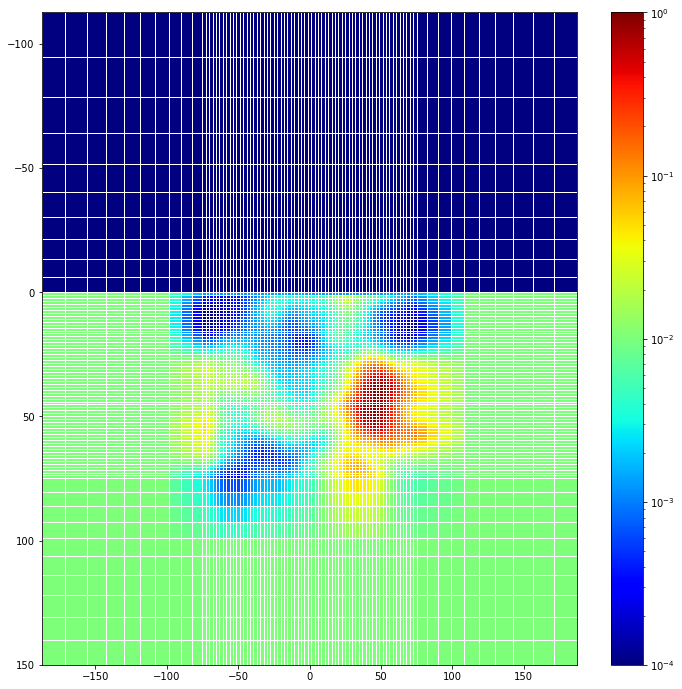

In [4]:
idx=40

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(1,1,1)
Y,Z = np.meshgrid(yn,zn)
h = ax.pcolormesh(Y/1e3,Z/1e3, sig[idx], 
                  norm=colors.LogNorm(vmin=1e-4, vmax=1e0),
                  edgecolors='white',
                  cmap='jet')
ax.invert_yaxis()
fig.colorbar(h)
plt.show()
# fig.savefig('../MT_CNN/imags/rho_model.jpg')

In [6]:
k = int(n_sample/num_cpus)
n_sample = int(k*num_cpus)

n_freq = np.size(freq)
n_ry   = len(ry)
rhoxy = np.zeros((n_sample,n_freq,n_ry),dtype=np_dtype) 
phsxy = np.zeros((n_sample,n_freq,n_ry),dtype=np_dtype)
rhoyx = np.zeros((n_sample,n_freq,n_ry),dtype=np_dtype)
phsyx = np.zeros((n_sample,n_freq,n_ry),dtype=np_dtype)
zxy   = np.zeros((n_sample,n_freq,n_ry),dtype=complex)
zyx   = np.zeros((n_sample,n_freq,n_ry),dtype=complex)

# rhoxy, phsxy,Zxy,rhoyx,phsyx,Zyx  = model.mt2d("TETM")
time0 = default_timer()

for ii in range(k):
    rhoxy[num_cpus*ii:num_cpus*(ii+1),:,:], phsxy[num_cpus*ii:num_cpus*(ii+1),:,:],zxy[num_cpus*ii:num_cpus*(ii+1),:,:],\
        rhoyx[num_cpus*ii:num_cpus*(ii+1),:,:],phsyx[num_cpus*ii:num_cpus*(ii+1),:,:],zyx[num_cpus*ii:num_cpus*(ii+1),:,:]  = \
        func_remote(nza, zn, yn, freq, ry, sig[num_cpus*ii:num_cpus*(ii+1),:,:],n_sample=num_cpus,mode="TETM")
    print(f"{ii} of {k} finished!")
    
time1 = default_timer()
# rhoxy, phsxy,Zxy, rhoyx, phsyx,Zyx  = model.mt2d("TETM")
# save_model(filename,resis, rhoxy, phsxy, rhoyx, phsyx)
print(f"time using: {time1-time0}s")

0 of 50 finished!
1 of 50 finished!
2 of 50 finished!
3 of 50 finished!
4 of 50 finished!
5 of 50 finished!
6 of 50 finished!
7 of 50 finished!
8 of 50 finished!
9 of 50 finished!
10 of 50 finished!
11 of 50 finished!
12 of 50 finished!
13 of 50 finished!
14 of 50 finished!
15 of 50 finished!
16 of 50 finished!
17 of 50 finished!
18 of 50 finished!
19 of 50 finished!
20 of 50 finished!
21 of 50 finished!
22 of 50 finished!
23 of 50 finished!
24 of 50 finished!
25 of 50 finished!
26 of 50 finished!
27 of 50 finished!
28 of 50 finished!
29 of 50 finished!
30 of 50 finished!
31 of 50 finished!
32 of 50 finished!
33 of 50 finished!
34 of 50 finished!
35 of 50 finished!
36 of 50 finished!
37 of 50 finished!
38 of 50 finished!
39 of 50 finished!
40 of 50 finished!
41 of 50 finished!
42 of 50 finished!
43 of 50 finished!
44 of 50 finished!
45 of 50 finished!
46 of 50 finished!
47 of 50 finished!
48 of 50 finished!
49 of 50 finished!
time using: 206.78166438799235s


In [10]:
scio.savemat(file_name,
             {'sig':sig,'zn':zn,'yn':yn,'ry':ry,'freq':freq,'nza':nza,
              'sig_k':sig_k,'zn0':zn0,'yn0':yn0,
                                'rhoxy':rhoxy, 'phsxy':phsxy, 
                                 'rhoyx':rhoyx, 'phsyx':phsyx})